<a href="https://colab.research.google.com/github/vgutierrezmendivil/SupervisedML/blob/main/NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aprendizaje Supervisado
# UdeSA, 2023
## Profesores: Marcela Svarc, Juan Manuel Pérez


## TP: Clasificación de tópicos de noticias



Alumnas: Victoria Gutierrez y Cecilia Sanseverino

Seteamos las librerías base y la configuración de warnings antes de comenzar

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 7.7 MB/s eta 0:00:00


# Conjunto de datos



Vamos a utilizar el conjunto de datos [AG News](https://huggingface.co/datasets/ag_news). Cada instancia del conjunto de datos consiste en un título y un cuerpo de una noticia, y una etiqueta que indica la categoría a la que pertenece. Las categorías son: 'World', 'Sports', 'Business' y 'Sci/Tech'.

| Texto                                                                                           | Categoría |
| ----------------------------------------------------------------------------------------------- | --------- |
| Wall St. Bears Claw Back Into the Black (Reuters) Reuters -.                                    | Business  |
| VIEW: Arafats ghost Barry Rubin Rarely in history has a political movement ...                  | World     |
| Tough loss for Pavano, Marlins ATLANTA -- All-Star pitcher Carl Pavano ...                      | Sports    |
| Digital ways to have fun including an HP-branded version of Apple's iPod - designed with an ... | Sci/Tech  |


In [ ]:
from datasets import load_dataset
# Con esto lo bajamos de este repositorio centralizado
ds = load_dataset("ag_news")

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [ ]:
column_names = ds["train"].column_names
print(column_names)

['text', 'label']


In [ ]:
# Convertimos a pandas
id2label = ds["train"].features["label"].names

df_train = ds["train"].to_pandas()

df_test = ds["test"].to_pandas()

## Analisis exploratorio

El conjunto de datos, como se explica anteriormente, está compuesto por un conjunto de noticias clasificadas en las siguientes 4 categorías:

In [ ]:
id2label

['World', 'Sports', 'Business', 'Sci/Tech']

Transformamos las labels en un diccionario y observamos la cantidad de noticias asociadas a cada una:

In [ ]:
label_dict = {i: name for i, name in enumerate(id2label)}
print(df_train['label'].value_counts().rename(index=label_dict))

Business    30000
Sci/Tech    30000
Sports      30000
World       30000
Name: label, dtype: int64


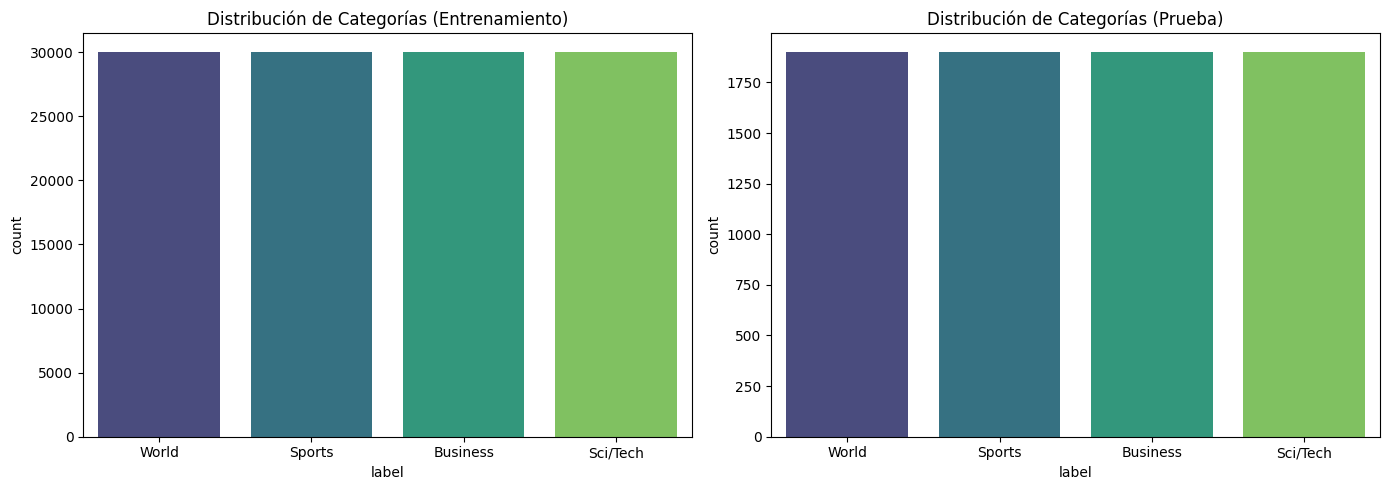

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Para el conjunto de entrenamiento
sns.countplot(data=df_train, x='label', palette='viridis', ax=axes[0])
axes[0].set_xticks(ticks=range(len(label_dict)))
axes[0].set_xticklabels(label_dict.values())
axes[0].set_title('Distribución de Categorías (Entrenamiento)')

# Para el conjunto de prueba
sns.countplot(data=df_test, x='label', palette='viridis', ax=axes[1])
axes[1].set_xticks(ticks=range(len(label_dict)))
axes[1].set_xticklabels(label_dict.values())
axes[1].set_title('Distribución de Categorías (Prueba)')

plt.tight_layout()
plt.show()

Como observamos en la descripción de las categorías y en los gráficos anteriores, las cuatro clases están balanceadas, tanto en la muestra de training como en la de test.

A continuacion, mostramos dos gráficos donde podemos observar la cantidad de palabras que poseen las noticias:

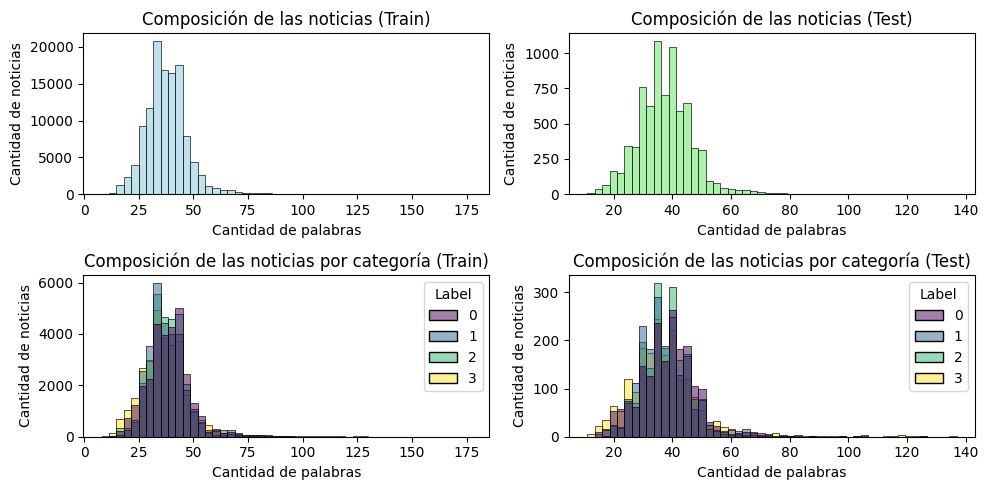

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))

# Muestra Train
sns.histplot(df_train['text'].apply(lambda x: len(x.split())), bins=50, color='lightblue', ax=axes[0,0])
axes[0,0].set_title('Composición de las noticias (Train)')
axes[0,0].set_xlabel('Cantidad de palabras')
axes[0,0].set_ylabel('Cantidad de noticias')

# Muestra Test
sns.histplot(df_test['text'].apply(lambda x: len(x.split())), bins=50, color='lightgreen', ax=axes[0,1])
axes[0,1].set_title('Composición de las noticias (Test)')
axes[0,1].set_xlabel('Cantidad de palabras')
axes[0,1].set_ylabel('Cantidad de noticias')

# Muestra Train (con categorías)
sns.histplot(df_train, x=df_train['text'].apply(lambda x: len(x.split())), hue="label", bins=50, palette='viridis', ax=axes[1,0])
axes[1,0].set_title('Composición de las noticias por categoría (Train)')
axes[1,0].set_xlabel('Cantidad de palabras')
axes[1,0].set_ylabel('Cantidad de noticias')
axes[1,0].get_legend().set_title("Label")

# Muestra Test (con categorías)
sns.histplot(df_test, x=df_test['text'].apply(lambda x: len(x.split())), hue="label", bins=50, palette='viridis', ax=axes[1,1])
axes[1,1].set_title('Composición de las noticias por categoría (Test)')
axes[1,1].set_xlabel('Cantidad de palabras')
axes[1,1].set_ylabel('Cantidad de noticias')
axes[1,1].get_legend().set_title("Label")

#Imprimimos los gráficos
plt.tight_layout()
plt.show()


Como se puede ver en los histogramas, la distribución de cantidad de palabras es similar para las 4 categorías.

Observamos las palabras más frecuentes por categoría:

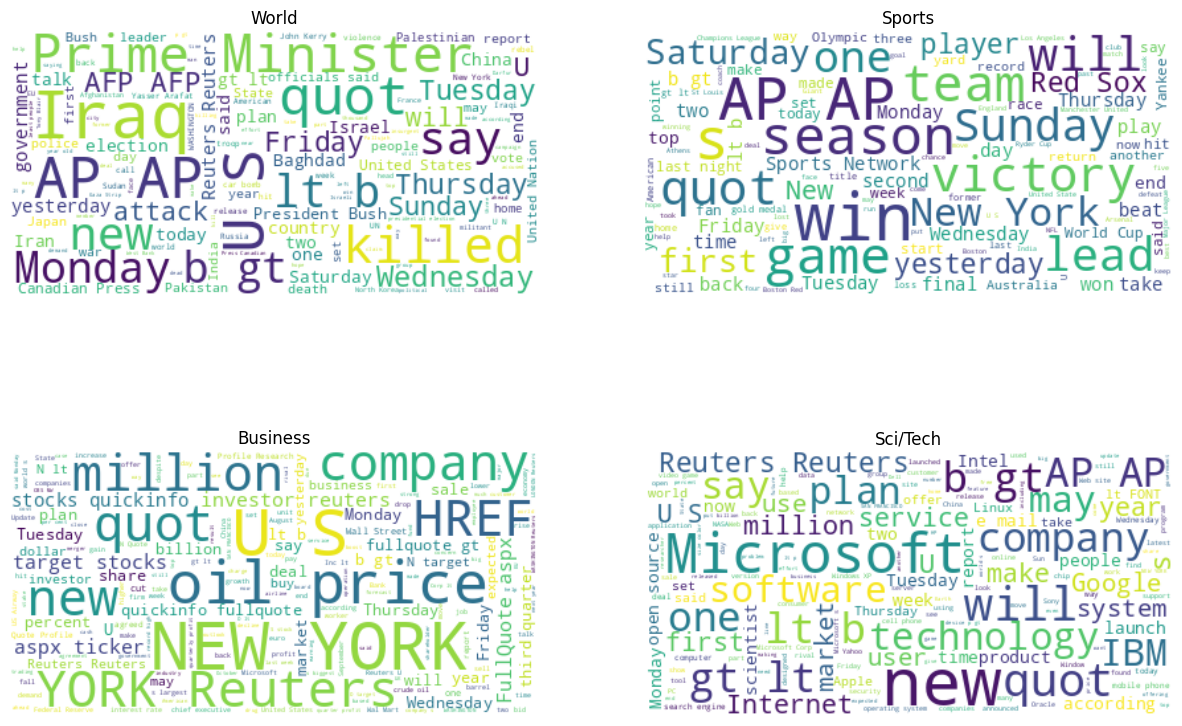

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(text, ax, title):
    wordcloud = WordCloud(max_font_size=50, max_words=25000, background_color="white").generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.axis('off')
    ax.set_title(title)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

categories = list(label_dict.values())
for i, cat in enumerate(categories):
    temp_df = df_train[df_train['label'] == i]
    text = ' '.join(temp_df['text'].tolist())
    plot_wordcloud(text, axes[i//2, i%2], cat)

# Optimización

Dividimos el dataframe en conjuntos X e Y train y test:

In [ ]:
X_train, y_train = df_train['text'], df_train['label']
X_test, y_test = df_test['text'], df_test['label']

Armamos una muestra de optimización del 10% de los datos de train y test:

In [ ]:
x_train_opt = X_train.sample(frac=0.10, random_state=42)
y_train_opt = y_train.sample(frac=0.10, random_state=42)

## Preprocesamiento

Aplicamos cross validación para determinar los parámetros del preprocesamiento. Utilizaremos Random Forest y Regresion Logistica como métodos de clasificación para elegir los valores óptimos.

Para la funcion TF-IDF le seteamos de entrada el parámetro stop_word = 'english', el cual ya excluye del análisis una lista de palabras del inglés que no aportarían información.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
texto_news = TfidfVectorizer(stop_words='english')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline = Pipeline([
    ('texto_news', texto_news),
    ('clf', RandomForestClassifier())
])

# Parametros para TF-IDF
params_texto = {
    'texto_news__max_df': [0.85, 0.9, 0.95],
    'texto_news__min_df': [2, 3, 5],
    'texto_news__ngram_range': [(1, 1), (1, 2)]
}

# Parámetros Random Forest
params_rf = {
    **params_texto,
    'clf': [RandomForestClassifier()]
}

# Parámetros Regresión Logistica
params_lr = {
    **params_texto,
    'clf': [LogisticRegression(solver='liblinear')]
}

params_all = [params_rf, params_lr]

grid_search = GridSearchCV(pipeline, params_all, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(x_train_opt, y_train_opt)

print("Mejor accuracy:", grid_search.best_score_)
print("Mejores Parámetros:", grid_search.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejor accuracy: 0.8961666666666666
Mejores Parámetros: {'clf': LogisticRegression(solver='liblinear'), 'texto_news__max_df': 0.85, 'texto_news__min_df': 2, 'texto_news__ngram_range': (1, 2)}


Dado el resultado anterior, seteamos los parámetros del algoritmo TF-IDF:

In [ ]:
texto_news_opt = TfidfVectorizer(max_features=25000, stop_words='english',
                                 max_df=0.85, min_df=2,ngram_range=(1, 2))

## Pipeline: Selección de parámetros de los modelos clasificadores

1) Importamos las librerías y métodos que necesitamos para armar el procesamiento

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_validate

2) Definimos las los datos para el pipeline.

Los clasificadores que vamos a contrastar son: Random Forest, Regresión Logística y KNN. A su vez, establecemos los parámetros a cross validar en cada caso.

In [ ]:
clasificadores = [
    ('Random Forest', RandomForestClassifier()),
    ('Logit', LogisticRegression()),
    ('KNN', KNeighborsClassifier())
]

parametros = {
    'Random Forest': {
        'classifier__n_estimators': [10, 50, 100],
        'classifier__max_depth': [None, 10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 4]
    },
    'Logit': {
        'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    }
}

3) Cross Validation de hiperparámetros utilizando la función GridSearchCV, la cual realiza la cross validación para cada modelo y nos devuelve el resultado que ha obtenido el mejor resultado.

Esta función toma los datos del pipeline (el texto y la lista de clasificadores), junto con los parámetros determinados anteriormente. Definimos cv=5 para que ejecute 5 Folds.

In [ ]:
for name, classifier in clasificadores:
    pipeline = Pipeline([
        ('texto_news', texto_news_opt),
        ('classifier', classifier)
    ])

    grid_search = GridSearchCV(pipeline, parametros[name], cv=5)
    grid_search.fit(x_train_opt, y_train_opt)

    print(f"Mejor accuracy para {name} en la CV: {grid_search.best_score_}")
    print(f"Mejores parámetros seleccionados: {grid_search.best_params_}")

Mejor accuracy para Random Forest en la CV: 0.8547499999999999
Mejores parámetros seleccionados: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}
Mejor accuracy para Logit en la CV: 0.8977499999999999
Mejores parámetros seleccionados: {'classifier__C': 10}
Mejor accuracy para KNN en la CV: 0.8664999999999999
Mejores parámetros seleccionados: {'classifier__metric': 'euclidean', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance'}


Definimos entonces que los parámetros para cada clasificador son:

**Random Forest:**
* Sin profundidad máxima
* Mínimo de observaciones por hoja: 2
* Mínimo de observaciones para dividir: 2
* Cantidad de árboles: 100

**Regresión logística**
* C: 10

**K Vecinos más cercanos (KNN):**
* Medida de distancia: Euclídea
* K Vecinos: 7
* Pesos: Por distancia.


Ahora, iniciamos el total del análisis con toda la muestra de train.

# Ajuste de los modelos

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

Para correr los modelos y comparar resultados, con el fin de seleccionar el mejor, haremos una partición en la muestra de train, separando el 75% para entrenar los modelos y el 25% para validar los resultados.

In [ ]:
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

## Random Forest

In [ ]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=None,
                                min_samples_leaf=2, min_samples_split=2,
                                random_state=42)

pipeline_rf = Pipeline([
    ('tfidf', texto_news_opt),
    ('clf', clf_rf)
])

pipeline_rf.fit(X_train_2, y_train_2)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.85, max_features=25000, min_df=2,
                                 ngram_range=(1, 2), stop_words='english')),
                ('clf',
                 RandomForestClassifier(min_samples_leaf=2, random_state=42))])

Vemos cómo quedó el árbol:

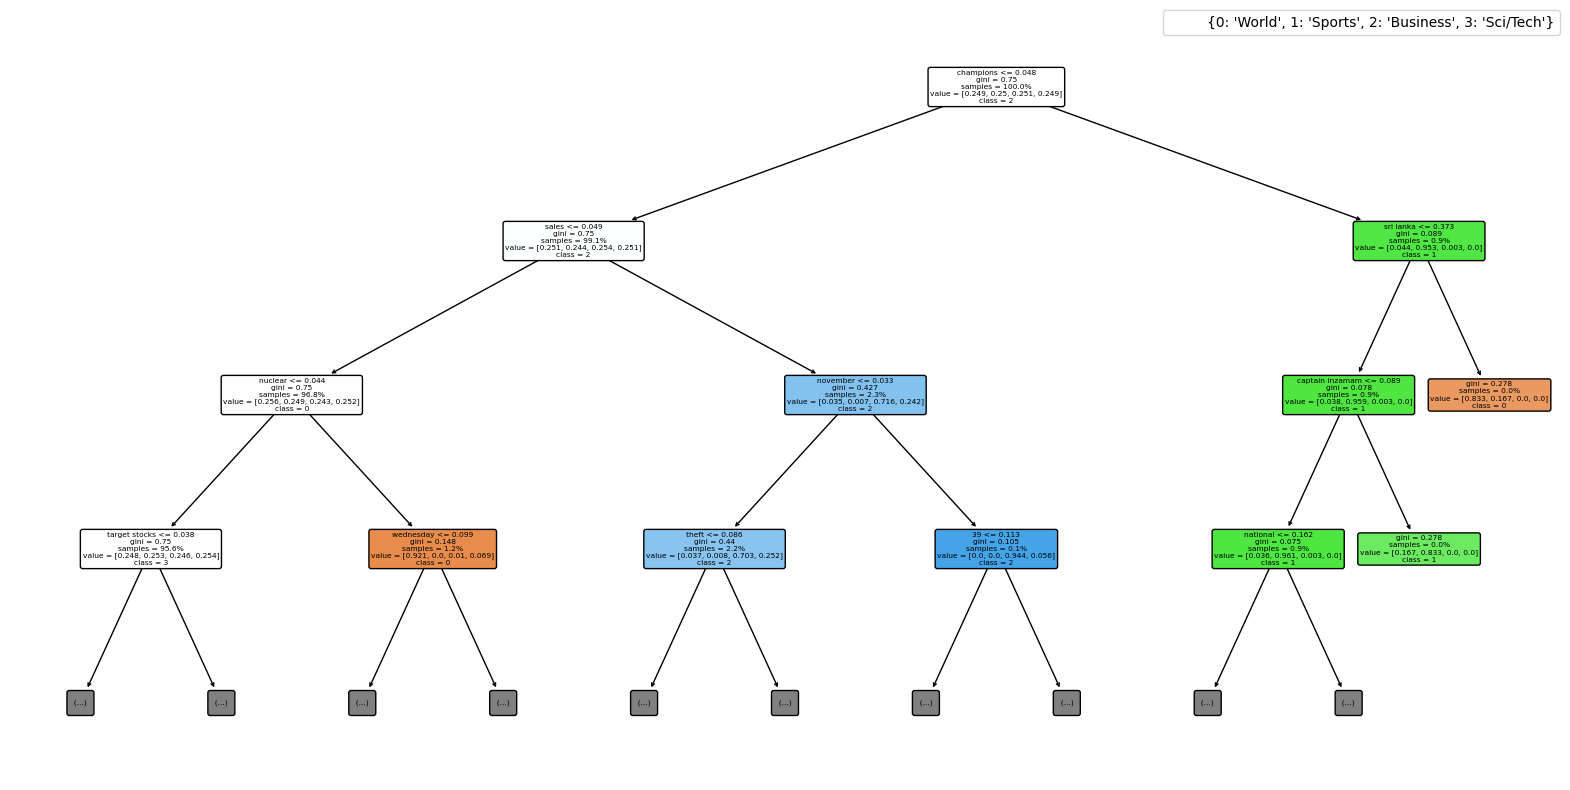

In [ ]:
from sklearn.tree import plot_tree
import matplotlib.patches as mpatches

clf_rf = pipeline_rf.named_steps['clf']
trees = clf_rf.estimators_
fitted_vectorizer = pipeline_rf.named_steps['tfidf']
class_names_str = [str(i) for i in clf_rf.classes_]

plt.figure(figsize=(20,10))
plot_tree(trees[0], filled=True, feature_names=fitted_vectorizer.get_feature_names_out(),
          class_names=class_names_str, max_depth=3, rounded=True, proportion=True)

clase_leyenda = {0: 'World', 1: 'Sports', 2: 'Business', 3: 'Sci/Tech'}
patches = [mpatches.Patch(color='white', label=clase_leyenda)]
plt.legend(handles=patches, loc='upper right', borderaxespad=0.)

plt.show()

Ahora observamos cómo se comporta con la muestra de validación y calculamos las métricas:

In [ ]:
y_pred = pipeline_rf.predict(X_val)

# Métricas
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

metrics_data = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
}

df_scores = pd.DataFrame(metrics_data)
print(df_scores)

   Accuracy  Precision    Recall  F1 Score
0  0.888267   0.887715  0.888267  0.887691


In [ ]:
# Matriz de confusión
nombres = ['World', 'Sports', 'Business', 'Sci/Tech']
conf_matrix = confusion_matrix(y_val, y_pred)
df_conf_matrix = pd.DataFrame(conf_matrix, columns=nombres, index=nombres)
print(df_conf_matrix)

          World  Sports  Business  Sci/Tech
World      6628     326       324       222
Sports       95    7276        64        65
Business    288     141      6417       654
Sci/Tech    363     228       582      6327


## Regresión logística

In [ ]:
clf_logistic = LogisticRegression(C=10)

pipeline_logistic = Pipeline([
    ('tfidf', texto_news),
    ('clf', clf_logistic)
])

pipeline_logistic.fit(X_train_2, y_train_2)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(C=10))])

In [ ]:
y_pred = pipeline_logistic.predict(X_val)

# Métricas
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

metrics_data = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
}

df_scores_logistic = pd.DataFrame(metrics_data)
print(df_scores_logistic)

   Accuracy  Precision    Recall  F1 Score
0  0.912067   0.911894  0.912067  0.911938


In [ ]:
# Matriz de confusión
nombres = ['World', 'Sports', 'Business', 'Sci/Tech']
conf_matrix_logit = confusion_matrix(y_val, y_pred)
df_conf_matrix_logit = pd.DataFrame(conf_matrix_logit, columns=nombres, index=nombres)
print(df_conf_matrix_logit)

          World  Sports  Business  Sci/Tech
World      6770     222       291       217
Sports      115    7306        41        38
Business    255      58      6592       595
Sci/Tech    224      49       533      6694


## KNN

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean', weights='distance')

pipeline_knn = Pipeline([
    ('tfidf', texto_news),
    ('clf', clf_knn)
])

pipeline_knn.fit(X_train_2, y_train_2)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=7,
                                      weights='distance'))])

In [ ]:
y_pred = pipeline_knn.predict(X_val)

# Métricas
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='weighted')
recall = recall_score(y_val, y_pred, average='weighted')
f1 = f1_score(y_val, y_pred, average='weighted')

metrics_data = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
}

df_scores_knn = pd.DataFrame(metrics_data)
print(df_scores_knn)

   Accuracy  Precision    Recall  F1 Score
0  0.906333   0.906165  0.906333  0.906166


In [ ]:
# Matriz de confusión
nombres = ['World', 'Sports', 'Business', 'Sci/Tech']
conf_matrix_knn = confusion_matrix(y_val, y_pred)
df_conf_matrix_knn = pd.DataFrame(conf_matrix_knn, columns=nombres, index=nombres)
print(df_conf_matrix_knn)

          World  Sports  Business  Sci/Tech
World      6693     249       347       211
Sports       93    7273        58        76
Business    254      89      6589       568
Sci/Tech    256      86       523      6635


Comparamos los tres clasificadores:

In [ ]:
df_scores['Classifier'] = 'Random Forest'
df_scores_logistic['Classifier'] = 'Logistic Regression'
df_scores_knn['Classifier'] = 'KNN'

df_all_scores = pd.concat([df_scores, df_scores_logistic, df_scores_knn], ignore_index=True)
df_all_scores = df_all_scores[['Classifier', 'Accuracy', 'Precision', 'Recall', 'F1 Score']]

print(df_all_scores)

            Classifier  Accuracy  Precision    Recall  F1 Score
0        Random Forest  0.888267   0.887715  0.888267  0.887691
1  Logistic Regression  0.912067   0.911894  0.912067  0.911938
2                  KNN  0.906333   0.906165  0.906333  0.906166


# Métricas finales

El mejor clasificador es la *Regresión Logística*, por lo que corremos el modelo sobre dicho algoritmo y reportamos las métricas definitivas.

In [ ]:
clf_logistic = LogisticRegression(C=10)

pipeline_logistic = Pipeline([
    ('tfidf', texto_news),
    ('clf', clf_logistic)
])

pipeline_logistic.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', LogisticRegression(C=10))])

In [ ]:
y_pred = pipeline_logistic.predict(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

metrics_data = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1 Score': [f1]
}

df_scores_logistic = pd.DataFrame(metrics_data)
print(df_scores_logistic)

   Accuracy  Precision    Recall  F1 Score
0  0.910395    0.91031  0.910395  0.910275


In [ ]:
# Matriz de confusión
nombres = ['World', 'Sports', 'Business', 'Sci/Tech']
conf_matrix_logit = confusion_matrix(y_test, y_pred)
df_conf_matrix_logit = pd.DataFrame(conf_matrix_logit, columns=nombres, index=nombres)
print(df_conf_matrix_logit)

          World  Sports  Business  Sci/Tech
World      1709      55        76        60
Sports       22    1851        17        10
Business     69      13      1659       159
Sci/Tech     51      17       132      1700
